<a href="https://colab.research.google.com/github/GeorgiosTheocharidis/intelligent_agents_lstm/blob/main/Designing_Intelligent_Agents_LSTM_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt   
import seaborn as sns

In [2]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [6]:
train=files.upload()

Saving train.csv to train (1).csv


In [18]:
subm=files.upload()

Saving sample_submission.csv to sample_submission.csv


In [7]:

test=files.upload()

Saving test.csv to test.csv


In [8]:
df_train=pd.concat(pd.read_csv(p) for p in train)
print(df_train)
df_test=pd.concat(pd.read_csv(p) for p in test)
print(df_test)
df_train.head()


                      id                                       comment_text  \
0       0000997932d777bf  Explanation\nWhy the edits made under my usern...   
1       000103f0d9cfb60f  D'aww! He matches this background colour I'm s...   
2       000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3       0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
4       0001d958c54c6e35  You, sir, are my hero. Any chance you remember...   
...                  ...                                                ...   
159566  ffe987279560d7ff  ":::::And for the second time of asking, when ...   
159567  ffea4adeee384e90  You should be ashamed of yourself \n\nThat is ...   
159568  ffee36eab5c267c9  Spitzer \n\nUmm, theres no actual article for ...   
159569  fff125370e4aaaf3  And it looks like it was actually you who put ...   
159570  fff46fc426af1f9a  "\nAnd ... I really don't think you understand...   

        toxic  severe_toxic  obscene  threat  insul

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


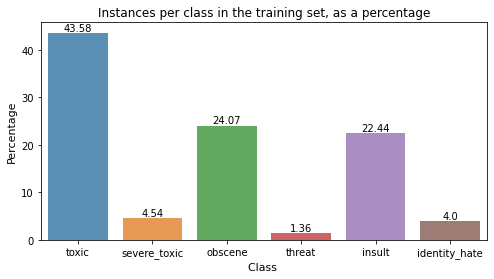

In [16]:
plt_values=df_train.iloc[:,2:].sum()
plt_sum=x=plt_values.sum()
plt_values=plt_values/plt_sum
plt_values*=100
plt_values=round(plt_values,2)
plt.figure(figsize=(8,4))
plt.title("Instances per class in the training set, as a percentage")
plt.xlabel('Class ', fontsize=11)
plt.ylabel('Percentage', fontsize=11)
occurances_plt= sns.barplot(plt_values.index, plt_values.values, alpha=0.8)
rects = occurances_plt.patches
labels = plt_values.values
for rect, label in zip(rects, labels):
    bar_height = rect.get_height()
    occurances_plt.text(rect.get_x() + rect.get_width()/2, bar_height , label, ha='center', va='bottom')

plt.show()

This means that the rest of the comments are clean, meaning 140k are not toxic. This creates an imbalance in the classes.

In [10]:
max_features = 25000
maxlen = 150

In [11]:
train_list = df_train["comment_text"].fillna(" ").values
test_list = df_test["comment_text"].fillna(" ").values
classes_title = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
df_train.head()
y = df_train[classes_title].values


In [12]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_list))
list_tokenized_train = tokenizer.texts_to_sequences(train_list)
list_tokenized_test = tokenizer.texts_to_sequences(test_list)
X_train = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = sequence.pad_sequences(list_tokenized_test, maxlen=maxlen)

In [13]:
def get_model():
    embed_size = 128
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size)(inp)
    x = Bidirectional(LSTM(50, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [14]:
model = get_model()
batch_size = 64
epochs = 1
file_path="toxic_comments_weights.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=20)

In [15]:
callbacks_list = [checkpoint, early] 
model.fit(X_train, y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks_list)

model.load_weights(file_path)

y_test = model.predict(X_test)

2244/2244 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9045
Epoch 1: val_loss improved from inf to 0.05048, saving model to toxic_comments_weights.best.hdf5
2244/2244 [==============================] - 633s 280ms/step - loss: 0.0717 - accuracy: 0.9045 - val_loss: 0.0505 - val_accuracy: 0.9940


In [21]:
df_subm=pd.concat(pd.read_csv(p) for p in subm)


In [24]:
df_subm[classes_title] = y_test
print(df_subm)

                      id     toxic  severe_toxic   obscene    threat  \
0       00001cee341fdb12  0.989244      0.292473  0.939350  0.025978   
1       0000247867823ef7  0.004487      0.000005  0.000380  0.000056   
2       00013b17ad220c46  0.003046      0.000003  0.000276  0.000030   
3       00017563c3f7919a  0.006382      0.000012  0.000823  0.000099   
4       00017695ad8997eb  0.013877      0.000022  0.001074  0.000228   
...                  ...       ...           ...       ...       ...   
153159  fffcd0960ee309b5  0.745181      0.006131  0.215998  0.014596   
153160  fffd7a9a6eb32c16  0.025456      0.000088  0.003552  0.000637   
153161  fffda9e8d6fafa9e  0.004396      0.000008  0.000578  0.000066   
153162  fffe8f1340a79fc2  0.008021      0.000018  0.001108  0.000148   
153163  ffffce3fb183ee80  0.935779      0.043703  0.685633  0.024047   

          insult  identity_hate  
0       0.843302       0.157007  
1       0.000869       0.000176  
2       0.000484       0.000105  

In [22]:
df_subm
df_subm.to_csv("baseline.csv", index=False)

Higest predicted value per class.                       0
toxic          0.998919
severe_toxic   0.564705
obscene        0.983805
threat         0.138292
insult         0.947074
identity_hate  0.248336


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


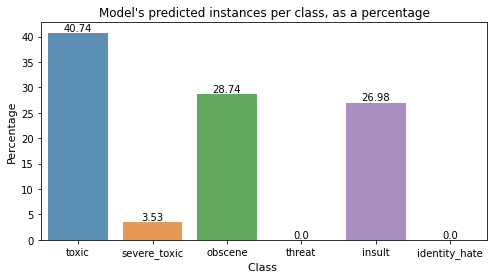

In [26]:
max_val_dict={}
inst_dict={}
inst_count=0
for i in df_subm[classes_title]:
  for z in df_subm[classes_title][i]:
      if z>0.3:
        inst_count+=1
  inst_dict[i] = inst_count
  max_value = df_subm[classes_title][i].max()
  max_val_dict[i] = max_value
  inst_count=0

maximum_pred=pd.DataFrame.from_dict(max_val_dict, orient='index')
print("Higest predicted value per class.",maximum_pred)

#Making the frequency plot for the predictions 
instances_plt=pd.DataFrame.from_dict(inst_dict, orient='index')
plt_values=instances_plt[0]
plt_sum=x=plt_values.sum()
plt_values=plt_values/plt_sum
plt_values*=100
plt_values=round(plt_values,2)
plt.figure(figsize=(8,4))
plt.title("Model's predicted instances per class, as a percentage")
plt.xlabel('Class ', fontsize=11)
plt.ylabel('Percentage', fontsize=11)
occurances_plt= sns.barplot(plt_values.index, plt_values.values, alpha=0.8)
rects = occurances_plt.patches
labels = plt_values.values
for rect, label in zip(rects, labels):
    bar_height = rect.get_height()
    occurances_plt.text(rect.get_x() + rect.get_width()/2, bar_height , label, ha='center', va='bottom')

plt.show()

